In [1]:
import pymysql
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('sharks_messy.csv', engine='python')
display(data.head())

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


In [3]:
print('shape:', data.shape)
print('types:\n\n', data.dtypes)
print('Null values:\n\n', data.isna().sum())

shape: (5992, 24)
types:

 Case Number               object
Date                      object
Year                       int64
Type                      object
Country                   object
Area                      object
Location                  object
Activity                  object
Name                      object
Sex                       object
Age                       object
Injury                    object
Fatal (Y/N)               object
Time                      object
Species                   object
Investigator or Source    object
pdf                       object
href formula              object
href                      object
Case Number.1             object
Case Number.2             object
original order             int64
Unnamed: 22               object
Unnamed: 23               object
dtype: object
Null values:

 Case Number                  0
Date                         0
Year                         0
Type                         0
Country                     

In [4]:
#printing info to evaluate if dropping
filtered_df = data[data['Unnamed: 22'].notnull()]
filtered_df1 = data[data['Unnamed: 23'].notnull()]
#display(filtered_df, filtered_df1)
#display(data[(data['Case Number'] != data['Case Number.1']) | (data['Case Number'] != data['Case Number.2'])][['Case Number', 'Case Number.1', 'Case Number.2']])
#display((data[data['href formula'] != data['href']][['href formula', 'href']]).head())
display((data[data['href formula'] != data['href']][['href formula', 'href']]).count())


href formula    53
href            51
dtype: int64

In [5]:
#dropping columns with no relevant info. Hypothesis not yet formulated. Just understanding the data and eliminating generic info. 
"""
1. Unnamed: 23 = All nulls except 1 showing: Teramo change filename
2. Unnamed: 22 = All nulls except 1 showing: stopped here
3. pdf: includes the data we already have in the table (further explained). Since we cannot work with this data = drop. 
In case is needed we can reference back to the original dataset.
4. Case Number == Case Number.1 == Case Number.2. Hay 13/5992 casos en los que son diferentes. Es una muestra muy peque
5. href formula, href and pdf mostly include the same pdf. There are around 53/5992 which have different values but after cheking
some of them, they lead to the same website. Since the sample is very small and will not affect significatively the results,
I'll eliminate the columns.

"""

data_clean = data.drop(['Unnamed: 23','Unnamed: 22', 'pdf','Case Number','Case Number.1', 'Case Number.2', 'href', 'href formula'], axis=1)


#display(data_clean.head())


### Hipotesis

**Hipotesis**: Somos los humanos las nuevas focas de los tiburones? 
Nos estan cazando o les estamos obligando a desplazarse de su habitat?. 

Para ello, asumo que si el tiburon se desplaza en verano puede que su idea sea la de cazar 
ya que hay mayor cantidad de personas en las playas y las convertimos en comederos. 
Si el tiburon se mueve por la orilla en invierno, puede que les estemos desplazando de su habitat.

A) Si el numero de ataques es similar en invierno que en verano = les estamos desplazando. No hay motivo alguno para que 
esten en la orilla. Hay menor cantidad de comida y ellos tienen menos movildiad.
B) Si ataques en verano > ataques en invierno == somos focas


KEY VALUES: SURFEROS (TAMBIEN PRACTICAN SURF EN INVIERNO. LUGAR (FECHAS DE VERANO DISTINTAS), NAME (TURISTA DE VACACIONES)
INJURY (EL TIBURON ESTABA JUGANDO VS ATACA *LEER IDEAS, ))


In [6]:
data_hypothesis = data_clean.drop(['Investigator or Source', 'original order'], axis=1)

In [7]:
display(data_hypothesis.shape)

(5992, 14)

In [8]:
#Getting the months numeric
def findMonth (m):
    months_dict = {
        'Jan': 1,
        'Feb': 2,
        'Mar': 3,
        'Apr': 4,
        'May': 5,
        'Jun': 6,
        'Jul': 7,
        'Aug': 8,
        'Sep': 9,
        'Oct': 10,
        'Nov': 11,
        'Dec': 12,             
    }
    for month, num in months_dict.items():
        if month in m:
            return int(num)
    return 0

data_hypothesis['Month'] = data_hypothesis['Date'].apply(findMonth)
#display(data_hypothesis.head())
data_hypothesis.shape

(5992, 15)

In [9]:
#Dropping rows where month = 0
dh_clean= data_hypothesis[data_hypothesis['Month'] & data_hypothesis['Year'] != 0].copy()

#Dropping column date. I don't need the days. With the column Month and Year it's enough
dh_clean_base = dh_clean.drop(['Date'], axis=1)

#display(dh_clean_base.head())
dh_clean_base.shape

(3793, 14)

In [10]:
#Creating a new dataframe with the columns to validate the hypothesis - level 1. When are more attacks? Winter vs summer.
#LEVEL2: dhf = dh_clean_base[['Year', 'Month', 'Country', 'Activity', 'Time', 'Age', 'Sex ', 'Fatal (Y/N)', 'Species ']]

dhf = dh_clean_base[['Year', 'Month', 'Country', 'Activity', 'Fatal (Y/N)']]
display(dhf.head())

,Year,Month,Country,Activity,Fatal (Y/N)
103,2015,12,SOUTH AFRICA,Kayak Fishing,N
104,2015,12,SPAIN,Swimming,N
105,2015,12,USA,Paddle boarding,N
106,2015,12,AUSTRALIA,Surfing,N
107,2015,12,BRAZIL,Scuba diving,N


In [11]:
#dh_clean_group= dh_clean_base[dh_clean_base['Month'] & data_hypothesis['Year'] != 0].copy()

In [12]:
#Attacks/year
year_size_sample = dhf.groupby(dhf['Year']).size()
display(year_size_sample.sort_values(axis = 0, ascending = False ).head(10))

Year
2015    139
2011    122
2014    121
2013    116
2007     97
2009     95
2012     91
2010     80
2005     78
1959     73
dtype: int64

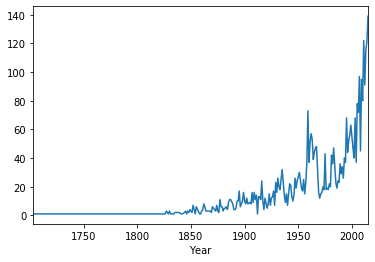

In [13]:
#Conclusion 1: More attacks are being registered along years: Are we invading their ecosystem? Are they hunting us?

year_size_sample = dhf.groupby(dhf['Year']).size()
year_size_sample.plot(x='Year', y='Year')

,Year,Month,Country,Activity,Fatal (Y/N)
103,2015,12,SOUTH AFRICA,Kayak Fishing,N
104,2015,12,SPAIN,Swimming,N
105,2015,12,USA,Paddle boarding,N
106,2015,12,AUSTRALIA,Surfing,N
107,2015,12,BRAZIL,Scuba diving,N


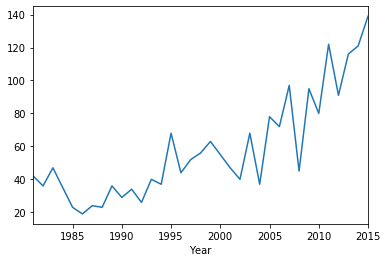

In [37]:
#To simplify and try more things: I am evaluating if current living sharks are learning that humans are a good source 
#of food + life expectancy of a shark is between 20-30 years, I will take into account only data since 1980s (30 + 10). 

dh_clean_years = dhf[dhf['Year'] > 1980].copy()
dh_clean_years.shape

dhf_years = dh_clean_years[['Year', 'Month', 'Country', 'Activity', 'Fatal (Y/N)']]
display(dhf_years.head())

year_size_sample1 = dhf_years.groupby(dhf_years['Year']).size()
#display (year_size_sample1.head())

year_size_sample1.plot(x='Year', y='Year')

In [38]:
year_fatal = dhf_years.groupby(dhf_years['Year', 'Fatal (Y/N)'])
display(year_fatal)    
    

KeyError: ('Year', 'Fatal (Y/N)')

In [30]:
#ataques mortales/year =(caza) no mortales/year = (defensa)

year_size_fatal= dhf_years.groupby(dhf_years['Fatal (Y/N)']).size()
display(year_size_fatal)

#year_fatal_alive = pd.dhf_years.groupby(dhf_years['Fatal Y/N'])

#df = pd.DataFrame(np.random.randn(1000, 4),
 #  ...:                   index=ts.index, columns=list('ABCD'))



#year_size_fatal.plot(x='Year', y='Year')






Fatal (Y/N)
N          1673
UNKNOWN      15
Y           259
dtype: int64

In [ ]:
#Asumo que si los tiburones nos estan cazando como minimo nos matan ya que es dificil que un humano enfrentandose
#a un tiburon consiga escaparse. Por lo tanto, si el humano sobrevive significa que el tiburon esta defendiendo el 
#territorio o se siente amenzado. 

In [18]:
countries_list11 = dhf_years.groupby(dhf_years['Fatal (Y/N)']).size()
display(countries_list11.head())

#Con los datos que he seleccionado tan solo se muestra que hay 259 fatales vs 1673 que sobreviven. Los tiburones no nos cazan,
#tan solo los humanos nos metemos en su territorio y ellos se defienden. Puede que debido a la pesca masiva, calentamiento global,
#u otros factores los tiburones se hayan desplazado hacia la costa y por tanto el numero de ataques se incrementa.

Fatal (Y/N)
N          1673
UNKNOWN      15
Y           259
dtype: int64

In [15]:
countries_list = dhf_years.groupby(dhf_years['Country']).size()
display(countries_list.head(100))

#Por simplificar, elimino los paises en los que hay < 5 ataques

Country
 TONGA                          2
ANTIGUA                         1
ARUBA                           1
ATLANTIC OCEAN                  2
AUSTRALIA                     302
AZORES                          2
BAHAMAS                        53
BELIZE                          1
BERMUDA                         1
BRAZIL                         65
BRITISH VIRGIN ISLANDS          1
CANADA                          1
CARIBBEAN SEA                   2
CAYMAN ISLANDS                  1
CHILE                           4
CHINA                           1
COLUMBIA                        2
COSTA RICA                      3
CROATIA                         2
CUBA                            4
DIEGO GARCIA                    1
DOMINICAN REPUBLIC              3
ECUADOR                         6
EGYPT                          14
EGYPT / ISRAEL                  1
EL SALVADOR                     3
ENGLAND                         3
FIJI                           13
FRANCE                          2
FRENCH

In [22]:
#From now on: Find out if sharks are attacking more during summer vs winter: 
#1. Separate between countries between hemispheres. North_Summer = Jul - Sept // South_summer = dec - Mar

countries_size = dhf_years.sort(dhf_years['Country']).size
display(dhf_years.head(20))


AttributeError: 'DataFrame' object has no attribute 'sort'

In [28]:
list_countriesh = []
southern_hemisphere = (
Africa,
Entirely,
Angola,
Botswana,
Burundi,
Comoros,
Eswatini,
Lesotho,
Madagascar,
Malawi,
Mauritius,
Mayotte,
Mozambique,
Namibia,
Réunion,
Rwanda,
Seychelles,

Tanzania,
Zambia,
Zimbabwe,
Mostly,

Gabon,

Partially,

Kenya,

Somalia,
Uganda,
Asia,
Entirely,
)

for e in southern_hemisphere.split(','):
    list_countriesh.append(e)
    





NameError: name 'Africa' is not defined

In [16]:
#todaytime pandas para convertir sep-2018 a 09-2018

#ideas: 
"""

1. Separate nocturnal species (people barely have a bath at night)
2. A very small percentage of shark species, about two dozen, are considered potentially 
dangerous to humans because of their size and dentition.
3. When a shark grabs a person by the hand/wrist and tows them along the surface, tosses a surfboard 
(or a Frisbee as in case 1968.08.24) it is probably "play behavior", not aggression. 
How can case GSAF 1971.04.11 which the swimmer was repeatedly bitten by a large shark and case 1985.01.04 in which 
the diver's injury necessitated a Band-aid be compared? 
4. Global Shark Attack File believes the only way to sort fact from hype is by forensic examination of each incident. 
5. Sexo: Male = mas comida porque somos mas grandes. Lo mismo con la edad.
6. fatal: quedan restos de comida? defienden su territorio
7. El nombre no lo elimino ya que me puede dar el genero en caso de que falte. 
8. Species me sirve para saber si el ataque ha sido con intencion de alimenartse (carnivoro), o defensa (herbivoro)
9. El anyo me hace falta para ver si estamos invadiendo su ecosistema y por eso se mueven mas cerca de las playas.
10. Reason: Sharks learn and remember what they have learned.
11.Avoid swimming at night. Reason: There is strong evidence to suggest that sharks move in closer 
to a land mass (island or shore) following sunset.
Avoid swimming in areas where birds are diving into the water. 
Reason: Diving birds indicate schools of fish are in the area and the likelihood that sharks in the area is increased.
"""







'\n\n1. Separate nocturnal species (people barely have a bath at night)\n2. A very small percentage of shark species, about two dozen, are considered potentially \ndangerous to humans because of their size and dentition.\n3. When a shark grabs a person by the hand/wrist and tows them along the surface, tosses a surfboard \n(or a Frisbee as in case 1968.08.24) it is probably "play behavior", not aggression. \nHow can case GSAF 1971.04.11 which the swimmer was repeatedly bitten by a large shark and case 1985.01.04 in which \nthe diver\'s injury necessitated a Band-aid be compared? \n4. Global Shark Attack File believes the only way to sort fact from hype is by forensic examination of each incident. \n5. Sexo: Male = mas comida porque somos mas grandes. Lo mismo con la edad.\n6. fatal: quedan restos de comida? defienden su territorio\n7. El nombre no lo elimino ya que me puede dar el genero en caso de que falte. \n8. Species me sirve para saber si el ataque ha sido con intencion de alimen